In [1]:
from autocnet_server.graph.graph import NetworkControlNetwork, NetworkCandidateGraph
from autocnet_server.db.model import Images, Overlay, Matches, Network
from autocnet_server.config import AutoCNet_Config as config

from sqlalchemy.orm import aliased, create_session, scoped_session, sessionmaker
from sqlalchemy import create_engine

In [2]:
sc = config()
db_uri = 'postgresql://{}:{}@{}:{}/{}'.format(sc.database_username,
                                              sc.database_password,
                                              sc.database_host,
                                              sc.database_port,
                                              sc.database_name)
engine = create_engine(db_uri)
connection = engine.connect()
session = sessionmaker(bind=engine)()

## Instantiate the controlling objects

In [3]:
ncg = NetworkCandidateGraph.from_database()

In [4]:
ncg.create_network()

In [7]:
!ls

01. NetworkCandidateGraph_Adding_Images.ipynb  slurm-1031484_12.out
02. Creating a Network Candidate Graph.ipynb   slurm-1031484_13.out
Deepen Visual Inspection.ipynb		       slurm-1031484_14.out
Generate_VRTs.ipynb			       slurm-1031484_15.out
Overlay.ipynb				       slurm-1031484_16.out
Processing Queues.ipynb			       slurm-1031484_17.out
ringmatch.sbatch_old			       slurm-1031484_18.out
slurm-1027684_100.out			       slurm-1031484_19.out
slurm-1027684_10.out			       slurm-1031484_1.out
slurm-1027684_11.out			       slurm-1031484_20.out
slurm-1027684_12.out			       slurm-1031484_21.out
slurm-1027684_13.out			       slurm-1031484_22.out
slurm-1027684_14.out			       slurm-1031484_23.out
slurm-1027684_15.out			       slurm-1031484_24.out
slurm-1027684_16.out			       slurm-1031484_25.out
slurm-1027684_17.out			       slurm-1031484_26.out
slurm-1027684_18.out			       slurm-1031484_27.out
slurm-1027684_19.out			       slurm-1031484_28.out
slurm-1027684_1.out			       slurm-1031484_

slurm-1030784_31.out			       slurm-1034584_40.out
slurm-1030784_32.out			       slurm-1034584_41.out
slurm-1030784_33.out			       slurm-1034584_42.out
slurm-1030784_34.out			       slurm-1034584_43.out
slurm-1030784_35.out			       slurm-1034584_44.out
slurm-1030784_36.out			       slurm-1034584_45.out
slurm-1030784_37.out			       slurm-1034584_46.out
slurm-1030784_38.out			       slurm-1034584_47.out
slurm-1030784_39.out			       slurm-1034584_48.out
slurm-1030784_3.out			       slurm-1034584_49.out
slurm-1030784_40.out			       slurm-1034584_4.out
slurm-1030784_41.out			       slurm-1034584_50.out
slurm-1030784_42.out			       slurm-1034584_51.out
slurm-1030784_43.out			       slurm-1034584_52.out
slurm-1030784_44.out			       slurm-1034584_53.out
slurm-1030784_45.out			       slurm-1034584_54.out
slurm-1030784_46.out			       slurm-1034584_55.out
slurm-1030784_47.out			       slurm-1034584_56.out
slurm-1030784_48.out			       slurm-1034584_57.out
slurm-1030784_49.out			       slu

In [5]:
import hotqueue as hq
import json
queue = hq.HotQueue("processor",
                    serializer=json,
                    host="smalls",
                    port=8000,
                    db=0)

In [6]:
queue.clear()

In [25]:
import ogr
f = 'POLYGON Z ((153.9720305617193 14.11288219582294 0, 153.988986142465 14.1148853346627 0, 154.035160664755 13.7366069760388 0, 154.0459876138069 13.6476753243032 0, 153.993062031284 13.9811487290627 0, 153.9720305617193 14.11288219582294 0))'
g = ogr.CreateGeometryFromWkt(f)
g.Area()
g.GetBoundary()

<osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x2b38ddfaef60> >

In [8]:
e = ncg.edges[(814, 1140)]['data']
for g, m in e.matches.groupby(['destination_idx']):
    if len(m) > 1:
        print(m)

        id  source  source_idx  destination  destination_idx       lat  \
24  928099     814      533713         1140           494307  5.081649   
47  859586     814      533712         1140           494307  5.081649   

           lon                                               geom    source_x  \
24  155.836508  01010000a08c7e0e00094757acc47a63404b74c8e29b53...  637.017212   
47  155.836508  01010000a08c7e0e00094757acc47a63404b74c8e29b53...  637.017212   

        source_y  destination_x  destination_y  
24  41722.148438    2335.210449      39376.125  
47  41722.148438    2335.210449      39376.125  


## Generate the overlaps, remove the overlaps have have only a single image intersecting.
The resultant geometries have 2+ images that should have points punched through.

In [4]:
from geoalchemy2.shape import to_shape 
import time

#TODO:
Since this runs over every overlapping polygon, it is trivial to parallelize on the cluster. Simply chunk out the overlapping geometries at some reasonable size and run $n$ concurrent jobs that write the results back to the redis queue and then on to the DB.

In [173]:
t1 = time.time()
oquery = session.query(Overlay)
iquery = session.query(Images)

commits = []
for q in query:
    commit = {'id':q.id, 'overlaps':[]}    
    qgeom = to_shape(q.geom)
    res = iquery.filter(Images.footprint_latlon.ST_Intersects(q.geom))
    for i in res:
        fgeom = to_shape(i.footprint_latlon)
        
        area = qgeom.intersection(fgeom).area
        if area < 1e-6:
            continue
        commit['overlaps'].append(i.id)
    commits.append(commit)
session.bulk_update_mappings(Overlay, commits)
session.commit()
t2 = time.time()
print(t2 - t1)

48.50995707511902


In [6]:
# This deletes the geometries that only have a single image overlapping.
# Something for the future, what happens if more images are streamed in?  Something for next year maybe?


oquery = session.query(Overlay)
from sqlalchemy import func
res = oquery.filter(func.cardinality(Overlay.overlaps) <= 1)
res.delete(synchronize_session=False)
session.commit()

## Get all of the correspondences that exist in a given geometry
This is prototyping for what should be a cluster job.

From here down is what the cluster job is going to need to do.

Compute Before Pushing
  * Polygon
  * Overlapping Edges
  * Fundamental Matrices
  * Reprojection Error
  * Compute k, scalar for the number of points to keep based on area. 0.002 looks like a good default

Push to the processing queue
  * Matches Data - as json
  * Polygon Bounds - list (minx, miny, maxx, maxy)
  * K 
  * Fundamental Matrices (dict of arrays) - do I need to convert to a list?
  * overlaps - list of tuples of edges

Push back to the completed queue
  * List of network objs in JSON form

In [5]:
from itertools import combinations
import pandas as pd

from autocnet.transformation.fundamental_matrix import compute_reprojection_error
from autocnet.utils.utils import make_homogeneous
import numpy as np
import math

[842, 986]


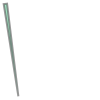

In [48]:
oquery = session.query(Overlay)
mquery = session.query(Matches)

def check_in(r, poly):
    p = to_shape(r.geom)
    return p.within(poly)

fundamentals = {}
for res in oquery:
    poly = to_shape(res.geom)
    overlaps = res.overlaps
    # Case n > 2 images
    matches = []
    # Merge together all of the points from all of the images and grab the fundamental matrices
    for e in combinations(res.overlaps, 2):
        edge = ncg.edges[e]['data']
        
        edge.compute_fundamental_matrix(method='ransac', reproj_threshold=20)
        fundamentals[e] = edge['fundamental_matrix']
        m = edge.matches
        err = compute_reprojection_error(edge['fundamental_matrix'],
                                         make_homogeneous(m[['source_x', 'source_y']].values), 
                                         make_homogeneous(m[['destination_x', 'destination_y']].values))

        m['strength'] = err
        matches.append(m)


    matches = pd.concat(matches)
    
    # Of the concatenated matches only a subset intersect the geometry for this overlap, pull these
    intersects = matches.apply(check_in, args=(poly,), axis=1)
    matches = matches[intersects]
    print(overlaps)
    break

len(matches)
poly

In [36]:
poly.area / 0.002

55.88188361500807

## Spatial Suppression

In [7]:
b = poly.bounds
minx = min(b[0], b[2])
maxx = max(b[0], b[2])
miny = min(b[1], b[3])
maxy = max(b[1], b[3])

domain = (maxx-minx),(maxy-miny)
min_radius = min(domain) / 20
max_radius = max(domain)
nsteps = 250
search_space = np.linspace(min_radius, max_radius, nsteps)
cell_sizes = search_space / math.sqrt(2)
min_idx = 0
max_idx = len(search_space) - 1

prev_min = None
prev_max = None

k = 60
error_k=0.05
df = matches
df = df.sort_values(by=['strength'], ascending=True).copy()
df = df.reset_index(drop=True)
mask = pd.Series(False, index=df.index)

process = True
while process:
    # Setup to store results
    result = []
    
    mid_idx = int((min_idx + max_idx) / 2)
    if min_idx == mid_idx or mid_idx == max_idx:
        warnings.warn('Unable to optimally solve.  Returning with {} points'.format(len(result)))
        process = False

    cell_size = cell_sizes[mid_idx]
    n_x_cells = int(round(domain[0] / cell_size, 0)) - 1
    n_y_cells = int(round(domain[1] / cell_size, 0)) - 1
    grid = np.zeros((n_y_cells, n_x_cells), dtype=np.bool)
    # Assign all points to bins
    x_edges = np.linspace(minx, maxx, n_x_cells)
    y_edges = np.linspace(miny, maxy, n_y_cells)
    xbins = np.digitize(df['lon'], bins=x_edges)
    ybins = np.digitize(df['lat'], bins=y_edges)

    # Convert bins to cells
    for i, (idx, p) in enumerate(df.iterrows()):
        x_center = xbins[i] - 1
        y_center = ybins[i] - 1
        cell = grid[y_center, x_center]
        
        if cell == False:
            result.append(idx)
            # Set the cell to True
            grid[y_center, x_center] = True
            
        if grid.all() == False:
            continue
    if k - k * error_k <= len(result) <= k + k * error_k:
        # Success, in bounds
        process = False
    elif len(result) < k - k * error_k:
        # The radius is too large
        max_idx = mid_idx
        if max_idx == 0:
            warnings.warn('Unable to retrieve {} points. Consider reducing the amount of points you request(k)'
                          .format(k))
            process = False
        if min_idx == max_idx:
            process = False
    elif len(result) > k + k * error_k:
        # Too many points, break
        min_idx = mid_idx
mask.loc[list(result)] = True
tp = df[mask]

In [8]:
print(cell_size)

0.0343841452562


In [9]:
x_edges
y_edges

array([ 11.10933357,  11.14985672,  11.19037987,  11.23090302,
        11.27142617,  11.31194932,  11.35247247,  11.39299562,
        11.43351877,  11.47404192,  11.51456507,  11.55508822])

In [10]:
grid

array([[False,  True, False, False,  True, False, False, False],
       [False,  True,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True, False,  True,  True, False],
       [False,  True,  True,  True,  True,  True, False, False],
       [False,  True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True,  True, False, False],
       [ True, False, False,  True,  True,  True, False, False],
       [False, False, False, False, False, False, False, False]], dtype=bool)

In [13]:
fig, ax = plt.subplots()
ax.set_xticks(x_edges, minor=False)
ax.set_yticks(y_edges, minor=False)
ax.plot(tp.lon.values, tp.lat.values, 'ro')
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')

NameError: name 'plt' is not defined

## Push these correspondences through

In [29]:
len(tp)

59

In [27]:
points = []
for g, subm in tp.groupby(['source', 'destination']):
    f = fundamentals[g]
    w = int(g[0])
    v = int(g[1])
        
    push_into = [i for i in overlaps if i not in g]
    
    x1 = make_homogeneous(subm[['source_x', 'source_y']].values)
    x2 = make_homogeneous(subm[['destination_x', 'destination_y']].values)
    
    for i in range(x1.shape[0]):
        row = subm.iloc[i]
        geom  = 'SRID=949900;POINTZ({} {} {})'.format(row.lon, row.lat, 0)
        a = x1[i]
        b = x2[i]

        p1 = Network(image_id=w,
                     keypoint_id=int(row.source_idx),
                     x = float(a[0]), y = float(a[1]), 
                     match_id=int(row.name),
                     point_id='TESTING', 
                     geom=geom)
        p2 = Network(image_id=v,
                     keypoint_id=int(row.destination_idx),
                     x = float(b[0]), y = float(b[1]), 
                     match_id=int(row.name),
                     point_id='TESTING',
                     geom=geom)
        
        points.append(p1)
        points.append(p2)
            
        for e in push_into:
            if w > e:
                f31 = [e,w]
                f31 = fundamentals[tuple(f31)].T
            else:
                f31 = [w,e]
                f31 = fundamentals[tuple(f31)]       

            if v > e:
                f32 = [e,v]
                f32 = fundamentals[tuple(f32)].T
            else:
                f32 = [v,e]
                f32 = fundamentals[tuple(f32)]


            x3 = np.cross(f31.dot(a), f32.dot(b))
            x3[0] /= x3[2]
            x3[1] /= x3[2]

            # This needs to aggregate all of the 
            n = Network(image_id=e,
                        keypoint_id=None, 
                        x=float(x3[0]), y=float(x3[1]),
                        point_id='TESTING',
                        geom=geom, match_id = None)


            points.append(n)

In [29]:
session.rollback()

In [28]:
len(points)

236

In [30]:
session.bulk_save_objects(points)
session.commit()